# RECOMMENDATION SYSTEM USING THE ALTERNATING LEAST SQUARE (ALS) ALGORITHM

## requirements.txt file

In [ ]:
!pip freeze > requirements.txt

## Import necessary labrary

In [ ]:
! pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
!pip install powerlaw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import urllib.request
from scipy.sparse import csr_matrix
import pandas as pd
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col
from pyspark.sql import SparkSession
from sklearn.metrics.pairwise import cosine_similarity
import powerlaw

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##  load a smaller MovieLens(ratings and movies) from drive dataset to develop and debug with

In [ ]:
ratings_df=pd.read_csv('/content/drive/MyDrive/APPLIED ML AT SCALE/ml-25m/rating.csv')
movies=pd.read_csv('/content/drive/MyDrive/APPLIED ML AT SCALE/ml-25m/movie.csv')
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
print ('ratings',ratings_df.shape)
print ('ratings',movies.shape)

(100836, 4)
(9742, 3)


## load a bigger MovieLens(ratings ) from drive dataset to develop and debug with

In [ ]:
ratings=pd.read_csv('/content/drive/MyDrive/APPLIED ML AT SCALE/ratings.csv')
ratings.shape
ratings.head(10)

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
5,1,1088,4.0,1147868495
6,1,1175,3.5,1147868826
7,1,1217,3.5,1147878326
8,1,1237,5.0,1147868839
9,1,1250,4.0,1147868414


# DATA PREPROCESSING

Let us do the pre-processing data to make sure that your userIds and movieIds start from 0 and no numbers will be jumped

In [20]:
#bigger dataset
U1,user_Id1 = np.unique(ratings['userId'], return_inverse=True)
ratings['userId'] = user_Id1
M1,movie_Id1 = np.unique(ratings['movieId'], return_inverse=True)
ratings['movieId'] = movie_Id1


In [21]:
#smaller dataset
U,user_Id = np.unique(ratings_df['userId'], return_inverse=True)
ratings_df['userId'] = user_Id
M,movie_Id = np.unique(ratings_df['movieId'], return_inverse=True)
ratings_df['movieId'] = movie_Id

ratings_df.head(10)

,userId,movieId,rating,timestamp
0,0,0,4.0,964982703
1,0,2,4.0,964981247
2,0,5,4.0,964982224
3,0,43,5.0,964983815
4,0,46,5.0,964982931
5,0,62,3.0,964982400
6,0,89,5.0,964980868
7,0,97,4.0,964982176
8,0,124,5.0,964984041
9,0,130,5.0,964984100


## Creates two dictionaries, one indexed by user and the other indexed by movie

In [22]:
#########Bigger dataset

# Create a dictionary indexed by user
def user_m_rating1(u_id):
  u_rating1 = ratings.loc[ratings['userId']== u_id, ['movieId','rating']]
  return list(zip(u_rating1['movieId'], u_rating1['rating']))

# Create a dictionary indexed by movie
def movie_u_rating1(m_id):
  m_rating1 = ratings.loc[ratings['movieId']== m_id, ['userId','rating']]
  return list(zip(m_rating1['userId'], m_rating1['rating']))

In [23]:
 #####smaller dataset
 
 # Create a dictionary indexed by user
def user_m_rating(u_id):
  u_ratings = ratings_df.loc[ratings_df['userId']== u_id, ['movieId','rating']]
  return list(zip(u_ratings['movieId'], u_ratings['rating']))

# Create a dictionary indexed by movie
def movie_u_rating(m_id):
  m_ratings = ratings_df.loc[ratings_df['movieId']== m_id, ['userId','rating']]
  return list(zip(m_ratings['userId'], m_ratings['rating']))



Creating two dictionaries, one indexed by user and the other indexed by movie, can be useful for several reasons:Efficient lookup, Aggregation and Data analysis.

 It can also enable us to perform more complex data analysis tasks that would be difficult or time-consuming to do without these dictionaries.

# DATA VISUALIZATION

most popular movies or the users who have given the highest ratings for smaller dataset

In [24]:
######smaller dataset

# Calculate the number of ratings for each movie
movie_ratings_count = ratings_df.groupby('movieId')['rating'].count()

# Sort the movies by the number of ratings in descending order
most_popular_movies = movie_ratings_count.sort_values(ascending=False)

# Print the top 10 most popular movies
print('Top 10 most popular movies:')
print(most_popular_movies.head(10))

# Calculate the average rating for each user
user_ratings_mean = ratings_df.groupby('userId')['rating'].mean()

# Sort the users by their average rating in descending order
highest_rated_users = user_ratings_mean.sort_values(ascending=False)

# Print the top 10 users with the highest average rating
print('\nTop 10 users: highest average rating:')
print(highest_rated_users.head(10))

Top 10 most popular movies:
movieId
314     329
277     317
257     307
510     279
1938    278
224     251
418     238
97      237
507     224
461     220
Name: rating, dtype: int64

Top 10 users: highest average rating:
userId
52     5.000000
250    4.869565
514    4.846154
24     4.807692
29     4.735294
522    4.693333
347    4.672727
170    4.634146
451    4.556931
42     4.552632
Name: rating, dtype: float64


most popular movies or the users who have given the highest ratings for bigger dataset

In [25]:
########Bigger dataset

# Calculate the number of ratings for each movie
movie_ratings_count = ratings.groupby('movieId')['rating'].count()

# Sort the movies by the number of ratings in descending order
most_popular_movies = movie_ratings_count.sort_values(ascending=False)

# Print the top 10 most popular movies
print('Top 10 most popular movies:')
print(most_popular_movies.head(10))

# Calculate the average rating for each user
user_ratings_mean = ratings.groupby('userId')['rating'].mean()

# Sort the users by their average rating in descending order
highest_rated_users = user_ratings_mean.sort_values(ascending=False)

# Print the top 10 users with the highest average rating
print('\nTop 10 users: highest average rating:')
print(highest_rated_users.head(10))

Top 10 most popular movies:
movieId
351     81491
314     81482
292     79672
585     74127
2480    72674
257     68717
475     64144
522     60411
108     59184
2867    58773
Name: rating, dtype: int64

Top 10 users: highest average rating:
userId
120484    5.0
25852     5.0
35588     5.0
95749     5.0
97236     5.0
147728    5.0
99881     5.0
126316    5.0
21356     5.0
113902    5.0
Name: rating, dtype: float64


These outputs can be useful for various purposes, such as recommending popular movies to new users or identifying users who are likely to enjoy certain types of movies.

## Plot rating distributions of data

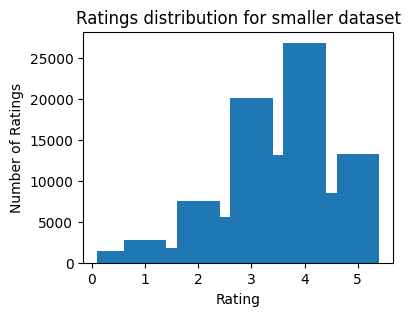

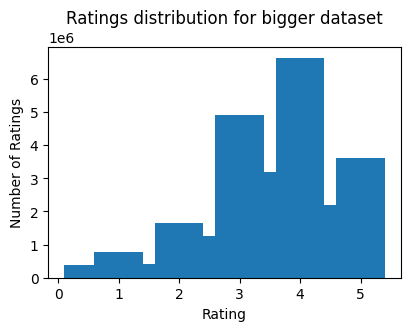

In [26]:


# Get the ratings distribution for smaller dataset
ratings_distribution = ratings_df['rating'].value_counts(sort=False)

# Get the ratings distribution for gigger dataset
rating_distribution = ratings['rating'].value_counts(sort=False)

# Plot the ratings distribution
plt.figure(figsize=(4,3))
plt.bar(ratings_distribution.index, ratings_distribution.values)
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.title('Ratings distribution for smaller dataset')
plt.show()

plt.figure(figsize=(4.55,3))
plt.bar(rating_distribution.index, rating_distribution.values)
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.title('Ratings distribution for bigger dataset')
plt.show()


Overall, the output of the code gives us a good understanding of the distribution of ratings in the MovieLens dataset. It tells us that the majority of ratings are positive (between 3.0 and 4.0) for both lots, but there is still some variability in the ratings (with some movies receiving very high or very low ratings).

## Are there power laws in the data? Is it scale-free?

Calculating best minimal value for power law fit
User degree distribution alpha for smaller datset: 2.065782057294177
Calculating best minimal value for power law fit
User degree distribution alpha for bigger datset: 3.835131002036216
Calculating best minimal value for power law fit
Movie degree distribution alpha for smaller datset: 2.7856330709862265
Calculating best minimal value for power law fit
Movie degree distribution alpha for bigger datset: 1.3915359226067774


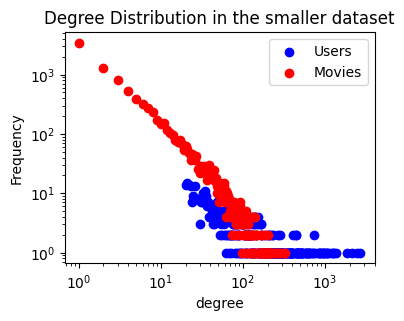

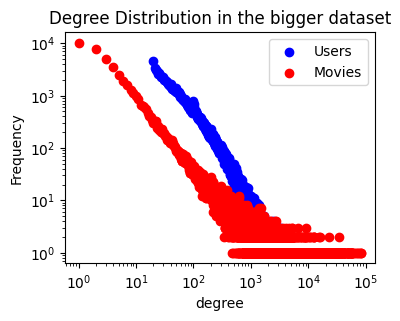

In [30]:
#number of movies watched by each user
user =  ratings_df.groupby('userId')['movieId'].count()
user1 =  ratings.groupby('userId')['movieId'].count()
# number of user for each movie
movie=  ratings_df.groupby('movieId')['userId'].count()
movie1=  ratings.groupby('movieId')['userId'].count()

u_d= list(user.to_dict().values())
m_d= list(movie.to_dict().values())

u_d1= list(user1.to_dict().values())
m_d1= list(movie1.to_dict().values())

u_f= Counter(user)
m_f= Counter(movie)

u_f1= Counter(user1)
m_f1= Counter(movie1)

u_x, u_y= zip(*sorted(u_f.items()))
m_x, m_y= zip(*sorted(m_f.items()))

u_x1, u_y1= zip(*sorted(u_f1.items()))
m_x1, m_y1= zip(*sorted(m_f1.items()))

# Fit a power law to the user degree distribution
user_fit = powerlaw.Fit(u_d, discrete=True)
print('User degree distribution alpha for smaller datset:', user_fit.power_law.alpha)

user_fit1 = powerlaw.Fit(u_d1, discrete=True)
print('User degree distribution alpha for bigger datset:', user_fit1.power_law.alpha)

# Fit a power law to the movie degree distribution
movie_fit = powerlaw.Fit(m_d, discrete=True)
print('Movie degree distribution alpha for smaller datset:', movie_fit.power_law.alpha)

movie_fit1 = powerlaw.Fit(m_d1, discrete=True)
print('Movie degree distribution alpha for bigger datset:', movie_fit1.power_law.alpha)

#plot of the data
plt.figure(figsize=(4,3))
plt.scatter(u_x, u_y, color='b', label='Users')
plt.scatter(m_x, m_y, color='r', label='Movies')
plt.xlabel('degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution in the smaller dataset')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show();

plt.figure(figsize=(4,3))
plt.scatter(u_x1, u_y1, color='b', label='Users')
plt.scatter(m_x1, m_y1, color='r', label='Movies')
plt.xlabel('degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution in the bigger dataset')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show();

 $\bullet$ Power Law: analyzing the result, we can see that degree distributions of users for both smaller and bigger datasets as well as degree distribution of movieId for  bigger dataset  follow a straight line on the log-log scale so these distribution follow a power law. 
 
 On the other hand,  the degree distribution of movieId For smaller dataset doesn't follow a straight line on the log-log scale so this distribution doesn't follow a power law. \\

 $\bullet$ scale-free:  From these values, we can see that both values of alpha for smaller dataset are  greater than 2,  these data are scale-free.  For bagger dataset, just User degree distribution alpha is greater than 2 but not the Movie degree distribution alpha. So only the data of user is scale-free here.

# TRAINING

## Build a model that finds maximum likelihood estimate for user + item biases with alternating least squares

In [31]:
#Iitialize user ad item
num_users = len(ratings_df['userId'].unique())
num_items = len(ratings_df['movieId'].unique())
print(num_items)
print(num_users)

9724
610


In [32]:
U_M_ratings, M_U_ratings = [], []

for m in range(num_users):
  U_M_ratings.append(user_m_rating(m))

for n in range(num_items):
  M_U_ratings.append(movie_u_rating(n))


In [33]:
#from types import LambdaType
user_bias = np.zeros(num_users)
item_bias = np.zeros(num_items)
lambda_ = 0.01
alpha=0.001

num_iterations = 30

loss, rmse = [], []
for iteration in range(num_iterations):
  # Update user biases
    for m in range(num_users):
        users_and_ratings = U_M_ratings[m]
        num = 0
        den =alpha  
        for i in range(len(users_and_ratings)):
            n, r = users_and_ratings[i][0], users_and_ratings[i][1] 
            num += lambda_ * (r - item_bias[n])
            den += lambda_
        user_bias[m] = num/ den 
        
  #  # Update item biases
    for n in range(num_items):
        items_and_ratings = M_U_ratings[n]
        num = 0
        den =  alpha 
        for i in range(len(items_and_ratings)):
            m, r = items_and_ratings[i][0],items_and_ratings[i][1] 
            num += lambda_ * (r - user_bias[m])
            den += lambda_ 
        item_bias[n] = num/ den 

    # calculate loss and rmse
    l_oss = -0.5*lambda_*np.sum((ratings_df['rating'] - (user_bias[ratings_df['userId']]+item_bias[ratings_df['movieId']]))**2) 
    l_oss-=((alpha/2)*np.sum(user_bias**2) + (alpha/2)*np.sum(item_bias**2))
    r_mse = np.sqrt(np.mean((ratings_df['rating'] - (user_bias[ratings_df['userId']]+item_bias[ratings_df['movieId']]))**2))
    loss.append(l_oss)
    rmse.append(r_mse)
    print('iteration' ,iteration+1 , ' loss :' , l_oss, 'rmse :', r_mse )

iteration 1  loss : -332.7361249254674 rmse : 0.8042892559344732
iteration 2  loss : -319.40059159297925 rmse : 0.787351246989288
iteration 3  loss : -318.50049822978485 rmse : 0.7860984760015699
iteration 4  loss : -318.41016026276077 rmse : 0.7859553639974229
iteration 5  loss : -318.38832973422274 rmse : 0.7859283608776728
iteration 6  loss : -318.37426374614233 rmse : 0.7859207973410269
iteration 7  loss : -318.36155163723544 rmse : 0.7859180965826755
iteration 8  loss : -318.3492837773243 rmse : 0.785916939306393
iteration 9  loss : -318.33729421775445 rmse : 0.7859163473552698
iteration 10  loss : -318.32554574127545 rmse : 0.7859159852409079
iteration 11  loss : -318.3140268717232 rmse : 0.7859157252709968
iteration 12  loss : -318.3027316716346 rmse : 0.7859155149887119
iteration 13  loss : -318.29165547791854 rmse : 0.7859153316248153
iteration 14  loss : -318.280793973329 rmse : 0.7859151648912193
iteration 15  loss : -318.27014298084106 rmse : 0.7859150099814565
iteration 16

## Plot the loss function (log likelihood) over training iterations and Plot the root mean square over iterations

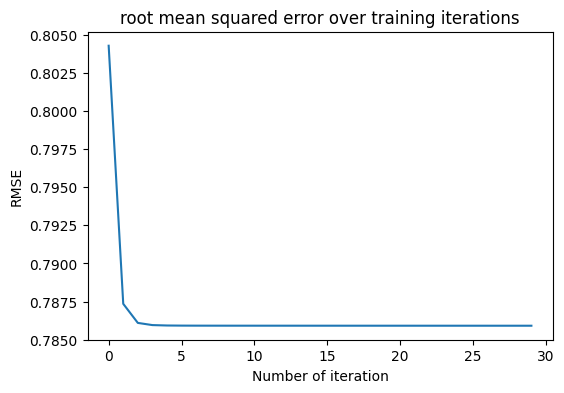

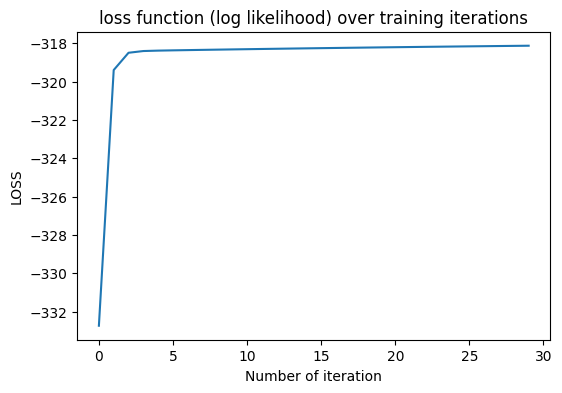

In [34]:
plt.figure(figsize=(6,4))
plt.plot(rmse)
plt.xlabel('Number of iteration')
plt.ylabel('RMSE')
plt.title('root mean squared error over training iterations')
plt.show()

plt.figure(figsize=(6.1,4))
plt.plot(loss)
plt.xlabel('Number of iteration')
plt.ylabel('LOSS')
plt.title('loss function (log likelihood) over training iterations')
plt.show()




The log likelihood  go up monotonically as we update the model parameters using alternating least squares. If the log likelihood does not increase monotonically, it may indicate a problem with the optimization algorithm or the model itself.

The RMSE is a measure of the difference between the predicted ratings and the actual ratings in the dataset. As the model parameters are updated using alternating least squares, the predicted ratings  become more accurate, leading to a decrease in the RMSE. However, there may be a point where further updates to the model parameters do not significantly improve the accuracy of the predicted ratings, and the RMSE reaches a minimum value of 0.78.

## Add user and item factors (latent trait vectors or matrices U and V), Add a sensible regularizer to your loss function, Build a model that finds maximum likelihood estimate for user + item biases + latent trait vectors / factors with alternating least squares

In [35]:
user_bias = np.zeros(num_users)
item_bias = np.zeros(num_items)

#Hyerarameters
lambda_ = 0.01
alpha=0.001
tau=0.04
num_iterations = 30

#num_factors and initializatio of user ad item factors
num_factors = 20
U = np.random.normal(0, 2.5/np.sqrt(num_factors), size=(num_users, num_factors))
V = np.random.normal(0, 2.5/np.sqrt(num_factors), size=(num_items, num_factors))

def loss_function():
    # Calculate predicted ratings
    predicted_ratings = np.dot(U, V.T)+ user_bias[:, np.newaxis]+item_bias[np.newaxis, :]
    error = ratings_df['rating'].values - predicted_ratings[ratings_df['userId'].values, ratings_df['movieId'].values]

    # Calculate total loss
    loss = -0.5*lambda_*np.sum(error**2) - 0.5*alpha * np.sum(user_bias**2) -0.5*alpha * np.sum(item_bias**2) \
           -0.5*tau*np.sum(U**2) + -0.5*tau*np.sum(V**2)

    # Calculating the RMSE
    rmse = np.sqrt(np.sum(error**2)/len(ratings_df['rating']))
    
    return loss, rmse


loss, rmse = [], []
for iteration in range(num_iterations):

  # Update user bias
    for m in range(num_users):
        users_and_ratings = U_M_ratings[m]

        num = 0
        den =  alpha 
        for i in range(len(users_and_ratings)):
            n, r = users_and_ratings[i][0], users_and_ratings[i][1] 
            U_for_user = U[m]
            V_for_user= V[n]
            num += lambda_ * (r - item_bias[n] - np.dot(U_for_user, V_for_user))
            den += lambda_
        user_bias[m] = num/ den 

     # Update  user factor
        A=0 
        B = tau*np.identity(num_factors)
        for i in range(len(users_and_ratings)):
            n, r = users_and_ratings[i][0], users_and_ratings[i][1] 
            U_for_user = U[m]
            V_for_user= V[n]
            A += lambda_*(r-user_bias[m]-item_bias[n])*V_for_user
            B +=   lambda_*np.outer(V_for_user,V_for_user)
        U[m] = np.linalg.solve(B, A)

        
        
    # Update item bias
    for n in range(num_items):
        items_and_ratings = M_U_ratings[n]
        num = 0
        den =  alpha 
        for i in range(len(items_and_ratings)):
            m, r = items_and_ratings[i][0],items_and_ratings[i][1]
            U_for_item = U[m]
            V_for_item= V[n]
            num += lambda_ * (r - user_bias[m]  - np.dot(U_for_item, V_for_item))
            den +=  lambda_
        item_bias[n] = num/ den 

       # Update  item factor
        A=0
        B = tau*np.identity(num_factors)
        for i in range(len(items_and_ratings)):
            m, r = items_and_ratings[i][0],items_and_ratings[i][1]
            U_for_item = U[m]
            V_for_item= V[n]
            A += lambda_*(r-user_bias[m]-item_bias[n])*U_for_item
            B +=   lambda_*np.outer(U_for_item,U_for_item)
        V[n] = np.linalg.solve(B, A)

    #calculate loss and rmse
    l_oss,r_mse = loss_function()
    loss.append(l_oss)
    rmse.append(r_mse)
    print('iteration' ,iteration+1 , ' loss :' , l_oss, 'rmse :', r_mse )

iteration 1  loss : -320.1213853889817 rmse : 0.75337195976305
iteration 2  loss : -222.1412796039456 rmse : 0.5434685787652564
iteration 3  loss : -199.988959843816 rmse : 0.48970384628286573
iteration 4  loss : -192.07789728752405 rmse : 0.4693038128868659
iteration 5  loss : -188.13809572452152 rmse : 0.4588703142152318
iteration 6  loss : -185.7625397330615 rmse : 0.4524497478837466
iteration 7  loss : -184.17631281020056 rmse : 0.4480941333648865
iteration 8  loss : -183.05008167803217 rmse : 0.4449734851593003
iteration 9  loss : -182.21261888971426 rmse : 0.4426422029354489
iteration 10  loss : -181.56706972153765 rmse : 0.44084018715676454
iteration 11  loss : -181.05566013503474 rmse : 0.43940986345305755
iteration 12  loss : -180.6418326320878 rmse : 0.4382505193693497
iteration 13  loss : -180.3011984925848 rmse : 0.43729441076487635
iteration 14  loss : -180.01679309513167 rmse : 0.4364943658403996
iteration 15  loss : -179.7763652456743 rmse : 0.43581651091215967
iteration

## Plot the loss function (log likelihood) over training iterations. It should go up monotonically!

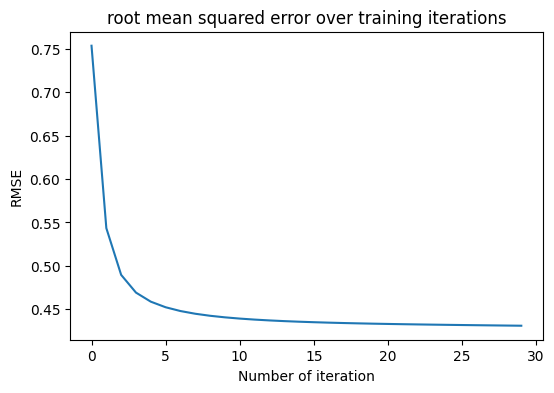

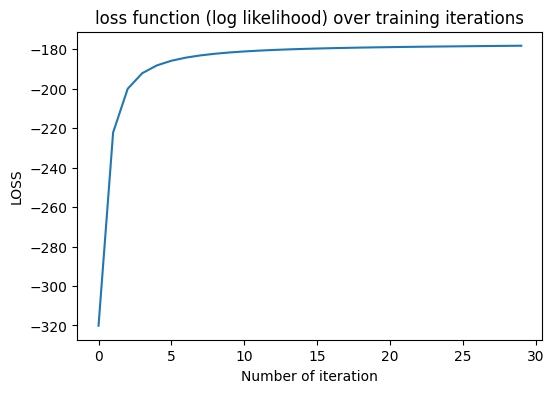

In [36]:
plt.figure(figsize=(6.1,4))
plt.plot(rmse)
plt.xlabel('Number of iteration')
plt.ylabel('RMSE')
plt.title('root mean squared error over training iterations')
plt.show()

plt.figure(figsize=(6,4))
plt.plot(loss)
plt.xlabel('Number of iteration')
plt.ylabel('LOSS')
plt.title('loss function (log likelihood) over training iterations')
plt.show()

$\bullet \textbf{Log Likelihood Plot}$: The log likelihood plot shows the improvement in the model's ability to predict user-item preferences over time. As the model is trained, the log likelihood increases, indicating that the model is becoming more accurate in its predictions. With the addition of latent factors, we can see a steeper increase in the log likelihood, indicating that the model is better able to capture complex relationships between users, items, and their preferences. This is a positive sign that the model is improving and becoming more accurate.\\

$\bullet \textbf{Root Mean Squared Error Plot}$: The root mean squared error plot shows the difference between the predicted ratings and the actual ratings for each user-item pair. As the model is trained, the root mean squared error decreases, indicating that the model is becoming more accurate in its predictions. With the addition of latent factors, we can see a faster decrease in the root mean squared error, indicating that the model is better able to capture complex relationships between users, items, and their preferences. This is a positive sign that the model is improving and becoming more accurate.

# Recommedations movies

In [37]:
#Make sure to just work with movies which have ID
C,mmovie_Id= np.unique(movies['movieId'] , return_inverse=True)
movies['movieId']=mmovie_Id

#Check the ID of the movie watched by the dummy user
print(movies[movies['title']=='Lord of the Rings: The Fellowship of the Ring, The (2001)'])

      movieId                                              title  \
3638     3638  Lord of the Rings: The Fellowship of the Ring,...   

                 genres  
3638  Adventure|Fantasy  


In [38]:
# First, let's create a dummy user who liked "Lord of the Rings" with a rating of 5
dummy_user = np.zeros(num_items)
movie_id = 3638 # This is the movie ID for "Lord of the Rings"
dummy_user[movie_id] = 5.0

# Next, let's calculate the predicted ratings for the dummy user
predicted_ratings = np.dot(U, V.T) + user_bias[:, np.newaxis] + item_bias[np.newaxis, :]
dummy_user_ratings = predicted_ratings[-1] + dummy_user

# Scale the predicted ratings to be between 0 and 5
max_predicted_rating = np.max(dummy_user_ratings)
scaled_ratings = dummy_user_ratings / max_predicted_rating * 5

# Now, let's sort the predicted ratings in descending order and get the top 10 movie IDs
top_movie_ids = np.argsort(scaled_ratings)[::-1][1:11]


#Finally, let's print out the top 10 recommended movies with their titles and genres
print("Top 10 recommended movies for the dummy user who liked 'Lord of the Rings':")
A, B,C = [], [],[]
for movie_id in top_movie_ids:
    movie_title = movies.loc[movies['movieId'] == movie_id]['title'].values[0]
    movie_genres = movies.loc[movies['movieId'] == movie_id]['genres'].values[0]
    predicted_ratings= scaled_ratings[movie_id]
    A.append(movie_title), B.append(movie_genres),C.append(predicted_ratings)
    #print(f" {movie_id} {movie_title} ({movie_genres})")

DF =  pd.DataFrame({'movieId': top_movie_ids, 'title': A, 'genres': B, 'predicted_ratings': C})
DF

Top 10 recommended movies for the dummy user who liked 'Lord of the Rings':


,movieId,title,genres,predicted_ratings
0,2013,Limbo (1999),Drama,3.750067
1,4039,"Eyewitness (Janitor, The) (1981)",Thriller,3.719770
2,4588,Three O'Clock High (1987),Comedy,3.719770
3,4156,"Story of O, The (Histoire d'O) (1975)",Drama|Romance,3.557566
4,6034,"Fog, The (2005)",Action|Horror|Mystery|Thriller,3.529770
5,8943,Tom and Jerry: Shiver Me Whiskers (2006),Animation|Children|Comedy,3.528215
6,973,Akira (1988),Action|Adventure|Animation|Sci-Fi,3.474625
7,2661,"Crow: Salvation, The (2000)",Action|Horror,3.459807
8,4044,"Four Seasons, The (1981)",Comedy|Drama,3.458468
9,5042,Notorious C.H.O. (2002),Comedy,3.458468


The output shows that the ALS algorithm has not successfully generated the recommended movies for the user based on their movie preferences. There could be several reasons why the predicted ratings for the top recommended movies are not the same genres as the movie watched by the dummy user. Here are some possible arguments:\\

$\bullet$ We didn't use the whole dataset so the recommendation system  doesn't have enough information about the dummy user's preferences to make accurate genre-based recommendations. For example, if the dummy user has only rated one movie, it may be difficult for the system to determine their genre preferences\\

$\bullet$ The recommendation system is based on the patterns and similarities in the user-item ratings matrix. It is possible that the dummy user's rating for "Lord of the Rings" is an outlier or does not fit well with the other ratings in the dataset. As a result, the system may recommend movies that are not necessarily similar in genre to "Lord of the Rings", but are more similar in terms of the overall rating patterns.\\

$\bullet$ The recommendation system may be biased towards certain genres or popular movies. For example, if the dataset contains a large number of ratings for action movies, the system may recommend more action movies even if the dummy user's preference is for a different genre.\\

# 'Napoleon Dynamite' effect

In [39]:

# Merge the movies and ratings dataframes
movie_ratings = pd.merge(movies, ratings_df, on='movieId')

# Pivot the dataframe to create a user-item matrix
user_item_matrix = movie_ratings.pivot_table(index='userId', columns='title', values='rating')

# Fill missing values with 0
user_item_matrix = user_item_matrix.fillna(0)

# Calculate the cosine similarity between the trait vectors of each movie
movie_similarity = cosine_similarity(user_item_matrix.T)

# Get the index of the "Napoleon Dynamite" movie
napoleon_index = movies[movies['title'] == 'Napoleon Dynamite (2004)'].index[0]

# Get the cosine similarity scores for the "Napoleon Dynamite" movie
napoleon_scores = movie_similarity[napoleon_index]

# Sort the scores in descending order
sorted_scores = sorted(list(enumerate(napoleon_scores)), key=lambda x: x[1], reverse=True)

# Print the top 10 movies with the highest cosine similarity scores
A,B,C=[],[],[]
for i in range(1, 11):
    movie_index = sorted_scores[i][0]
    movie_title = movies.iloc[movie_index]['title']
    movie_genres = movies.iloc[movie_index]['genres']
    similarity_score = sorted_scores[i][1]
    A.append(movie_title), B.append( similarity_score), C.append( movie_genres)
    
D =  pd.DataFrame({ 'title': A, 'genres': C, 'similarity_score': B })
D

,title,genres,similarity_score
0,Sleepless in Seattle (1993),Comedy|Drama|Romance,1.0
1,Nothing to Lose (1994),Action|Crime|Drama,1.0
2,Cyrano de Bergerac (1990),Comedy|Drama|Romance,1.0
3,Audrey Rose (1977),Horror,1.0
4,Men in Black (a.k.a. MIB) (1997),Action|Comedy|Sci-Fi,1.0
5,"Mrs. Brown (a.k.a. Her Majesty, Mrs. Brown) (1...",Drama|Romance,1.0
6,Stranger in the House (1997),Thriller,1.0
7,"Broadway Melody, The (1929)",Musical,1.0
8,Air Bud: Golden Receiver (1998),Children|Comedy,1.0
9,"Best Man, The (Testimone dello sposo, Il) (1998)",Comedy|Drama|Romance,1.0


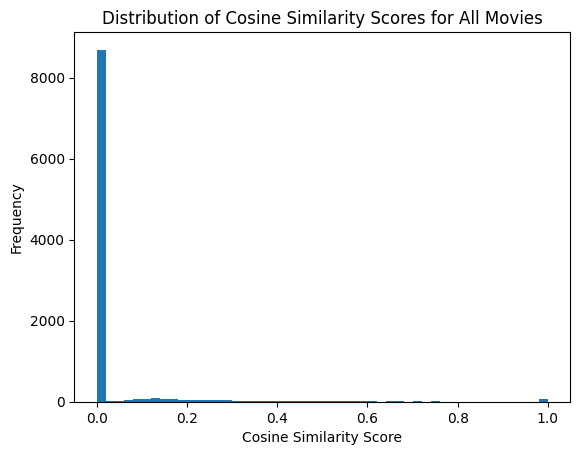

In [40]:
# Plot a histogram of the cosine similarity scores
plt.hist(napoleon_scores, bins=50)
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of Cosine Similarity Scores for All Movies')
plt.show()

The histogram plot of the cosine similarity scores shows the distribution of similarity scores for all movies in the dataset. We can use this plot to identify movies with unusually long trait vectors, which are likely to have the "Napoleon Dynamite" effect. These movies are very few and are likely to be highly polarizing and can quickly narrow down a user's taste once we know whether they like or dislike it. We can also see a lot of movies (3500) don't present the  "Napoleon Dynamite" effect because their cosine similarity score are very closed to 0.

## 2D embeddings

In [41]:
# Create a dictionary of movie IDs to genres
movie_id_to_genre = {}
for index, row in movies.iterrows():
    movie_id_to_genre[row['movieId']] = row['genres'].split('|')
# Create a dictionary of movie IDs to indices
movie_id_to_index = {}
for i, movie_id in enumerate(ratings_df['movieId'].unique()):
    movie_id_to_index[movie_id] = i

# Create a dictionary of user IDs to indices
user_id_to_index = {}
for i, user_id in enumerate(ratings_df['userId'].unique()):
    user_id_to_index[user_id] = i

# Convert the movie and user IDs to indices
ratings_df['movie_index'] = ratings_df['movieId'].apply(lambda x: movie_id_to_index[x])
ratings_df['user_index'] = ratings_df['userId'].apply(lambda x: user_id_to_index[x])

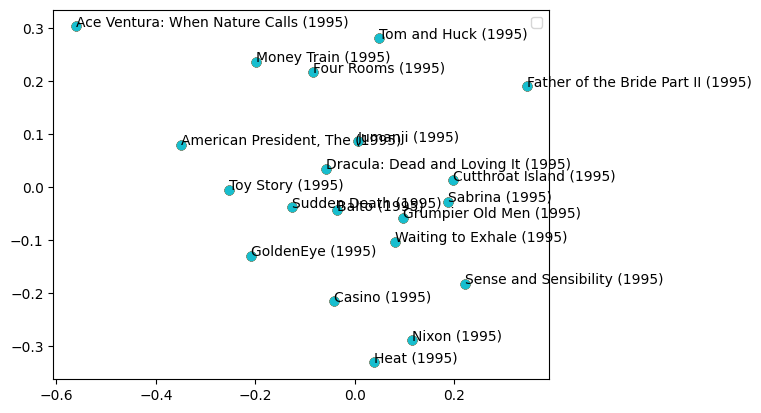

In [42]:
# Plot the 2D embeddings of the item trait vectors
movie_embeddings = V.T
movie_names = ['Toy Story (1995)', 'Jumanji (1995)', 'Grumpier Old Men (1995)',  'Waiting to Exhale (1995)', 
               'Father of the Bride Part II (1995)',  'Heat (1995)', 'Sabrina (1995)', 'Tom and Huck (1995)', 'Sudden Death (1995)', 
               'GoldenEye (1995)', 'American President, The (1995)', 'Dracula: Dead and Loving It (1995)', 'Balto (1995)', 'Nixon (1995)', 
               'Cutthroat Island (1995)', 'Casino (1995)', 'Sense and Sensibility (1995)', 'Four Rooms (1995)',
               'Ace Ventura: When Nature Calls (1995)', 'Money Train (1995)'   ]
movie_indices = [movie_id_to_index[movie_id] for movie_id in ratings_df['movieId'].unique()[:50] if movie_id_to_index[movie_id] < len(movie_names)]
movie_embeddings = movie_embeddings[:, movie_indices]

for i ,movie_index in enumerate(movie_indices):
      plt.scatter(movie_embeddings[0], movie_embeddings[1])
      plt.annotate(movie_names[i], (movie_embeddings[0][i], movie_embeddings[1][i]))
plt.legend()
plt.show()




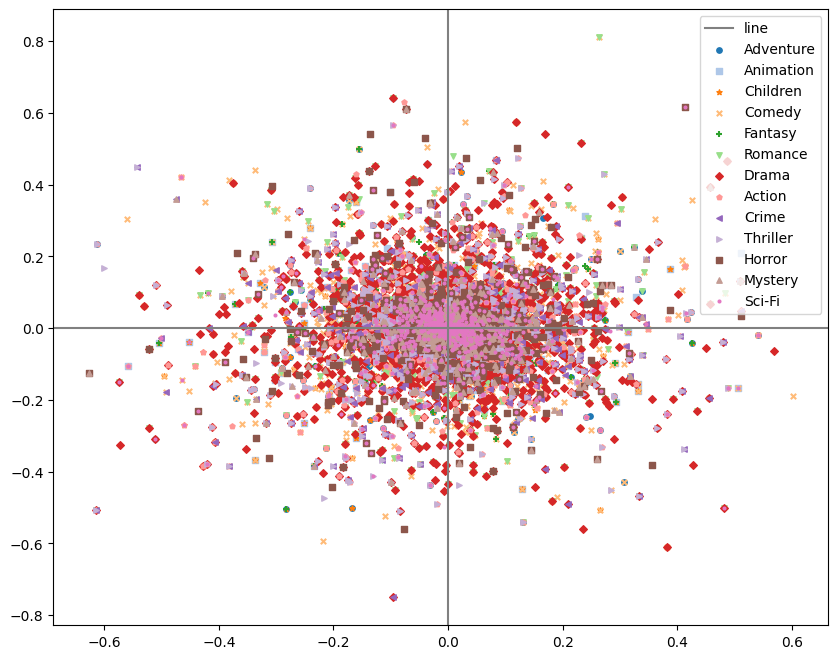

In [43]:
# Create a dictionary of movie IDs to indices
movie_id_to_index = {}
for i, movie_id in enumerate(ratings_df['movieId'].unique()):
    movie_id_to_index[movie_id] = i

# Create a dictionary of user IDs to indices
user_id_to_index = {}
for i, user_id in enumerate(ratings_df['userId'].unique()):
    user_id_to_index[user_id] = i

# Convert the movie and user IDs to indices
ratings_df['movie_index'] = ratings_df['movieId'].apply(lambda x: movie_id_to_index[x])
ratings_df['user_index'] = ratings_df['userId'].apply(lambda x: user_id_to_index[x])

# Create a list of markers and colors for each genre
genres = movies['genres'].str.split('|', expand=True).stack().unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(genres)))
markers = ['o', 's', '*', 'x', '+','v','D','p','<', '>',',','^','.']



# Plot the 2D embeddings of the item trait vectors with markers and colors
movie_embeddings = V.T
fig, ax = plt.subplots(figsize=(10, 8))

ax.axhline(y=0, color='gray', linestyle='-', label='line')
ax.axvline(x=0, color='gray', linestyle='-')
for i, (genre, color, marker) in enumerate(zip(genres, colors, markers)):
    genre_movies = movies[movies['genres'].str.contains(genre)]
    movie_indices = [movie_id_to_index[movie_id] for movie_id in genre_movies['movieId'].unique() if movie_id in movie_id_to_index]
    movie_embeddings_genre = movie_embeddings[:, movie_indices]
    ax.scatter(movie_embeddings_genre[0], movie_embeddings_genre[1], color=color, marker=marker, label=genre, s=15)
ax.legend()
plt.show()



The plot enables us to see whether movies of different genres cluster together in the 2D space. If we observe that movies of a particular genre cluster together, it suggests that there is a strong relationship between the traits of movies in that genre and that these traits may be important predictors of user ratings for that genre